In [1]:
import pandas as pd
import numpy as np
import pymorphy2
from matplotlib.colors import ListedColormap
from numpy.random import choice
from matplotlib import pyplot as plt

import re

from gensim.models import FastText,KeyedVectors,fasttext

from sklearn import metrics

from scipy import spatial

import torch

from transformers import AutoTokenizer, AutoModel

'''import tensorflow as tf
from tensorflow.keras.layers import Reshape,BatchNormalization,MaxPooling2D,Lambda
from tensorflow.keras.layers import Dense,Activation,Reshape,Conv2D,LeakyReLU,concatenate,Flatten
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop, Adam
'''
from sklearn.model_selection import train_test_split
from sklearn import cluster

import seaborn as sns
import umap

C:\Anaconda\envs\torch\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## FAQ

### Get data

In [103]:
faq=pd.read_csv('faq.csv')
faq.head(5)

,Question,Answer
0,Как изменить ФИО собственника?,Для переоформления лицевого счета на нового вл...
1,Как исправить ошибку (или опечатку) в ФИОсобст...,Подать заявку на изменение данных можно в личн...
2,Как изменить телефон?,Изменить номер мобильного телефона можно самос...
3,Как изменить количество проживающих?,Изменить данные о количестве проживающих можно...
4,Как изменить количество комнат?,Изменить данные о количестве комнат можно толь...


### Question answering

In [3]:
class SearchEngine():
    def __init__(self,faq,sbert_name=False,fasttext_path=False):
        self.faq=faq
        if sbert_name:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.sbert_model = AutoModel.from_pretrained(sbert_name)
            self.sbert_model.to(self.device)
            self.sbert_tokenizer = AutoTokenizer.from_pretrained(sbert_name)
            self.sbert_faq_embs=np.array([self.vectorize_sentence_sbert(sent) for sent in self.faq[:,0]])
            
        if fasttext_path:
            self.ft_model= fasttext.FastTextKeyedVectors.load(fasttext_path)
            self.ft_faq_embs=np.array([self.vectorize_sentence_ft(sent) for sent in self.faq[:,0]])
        
    def vectorize_sentence_ft(self,sentence):
        txt=sentence.split()
        val=0
        for word in txt:
            val+=self.ft_model[word]

        return val/len(txt)
    

    def vectorize_sentence_sbert(self,sentence):
    
        encoded_input = self.sbert_tokenizer(sentence,
                                             padding=True,
                                             truncation=True,
                                             max_length=24,
                                             return_tensors='pt').to(self.device)

   #     with torch.no_grad():
        model_output = self.sbert_model(**encoded_input)
            
        #Perform pooling. In this case, mean pooling
        sentence_embedding = self.mean_pooling(model_output, encoded_input['attention_mask'])
        sentence_embedding = np.squeeze(sentence_embedding)
        
        return sentence_embedding.cpu().data.numpy()
    

    
    @classmethod
    def mean_pooling(cls,model_output, attention_mask):
        #Mean Pooling - Take attention mask into account for correct averaging
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask
    
    def search_faq(self,question,eps,minimal_score,mode,beta):
        if mode=='fasttext':
            vectorizer=self.vectorize_sentence_ft
            faq_embs=self.ft_faq_embs
        elif mode=='sbert':
            vectorizer=self.vectorize_sentence_sbert
            faq_embs=self.sbert_faq_embs

        question_emb=vectorizer(question)
        score=np.zeros((self.faq.shape[0],1))

       
        for i,faq_emb in enumerate(faq_embs):

            distance=1-spatial.distance.cosine( faq_emb,question_emb)
            score[i,0]=distance
                 
        
        faq_logits=np.concatenate([faq,faq_embs,score],axis=1)
        faq_logits=faq_logits[faq_logits[:, 3].argsort()]
        faq_logits=faq_logits[::-1]


        max_score=faq_logits[0,3]
        display_num=0

        for scr in faq_logits[:,2]:
            if max_score-scr<eps and scr > minimal_score:
                display_num+=1
            else:
                break
         


        
        return faq_logits[:display_num]
    


In [104]:
%%time
sbert_name="sberbank-ai/sbert_large_mt_nlu_ru"
# https://rusvectores.org/ru/models/
fasttext_path='weights/model.model'
engine=SearchEngine(faq.values,sbert_name,fasttext_path)


Wall time: 17.3 s


In [142]:
%%time
noise=' пук кряк пиво интерал'
noise2=' а то я не умею'
question=faq['Question'][51] +noise2+noise
#question='Как оформить льготу '
question='льгота  от расхода'
#question='Как будут осуществляться начисления если счетчик сломается'
print('Question: ',question)
print('---------------------')

eps=0.15
minimal_score=0.72
beta=1.5

modes=['fasttext','sbert','both']
mode=modes[1]
vectorizer=engine.vectorize_sentence_sbert

output=search_faq(engine,question,eps,minimal_score,mode=mode,beta=beta)

min_val=0.5
#cleaned_question=clean_question(SearchEngine.vectorize_sentence_ft,question,output[:,0],min_val)
#print(output)
print('---------------------')
#print('Cleaned question:',cleaned_question)
print('---------------------')


Question:  льгота  от расхода
---------------------
---------------------
---------------------
Wall time: 24.9 ms


In [105]:
 def calculate_faq(question_emb,faq_embs,eps,minimal_score,mode):

        score=np.zeros((engine.faq.shape[0],1))
        for i,faq_emb in enumerate(faq_embs):
            
            distance=1-spatial.distance.cosine( faq_emb,question_emb)
            score[i,0]=round(distance,4)
                 
        index=np.arange(len(engine.faq)).reshape((-1,1))
        
        questions=engine.faq[:,0].reshape((-1,1))
        
        faq_logits=np.concatenate([index,score],axis=1)
        faq_logits=faq_logits[faq_logits[:, 1].argsort()]
        faq_logits=faq_logits[::-1]


        max_score=faq_logits[0,1]
        display_num=0

        for scr in faq_logits[:,1]:
            if max_score-scr<eps and scr > minimal_score:
                display_num+=1
            else:
                break
         
        faq_logits=faq_logits[:display_num]
        
        
        return faq_logits
    

In [132]:
def find_faq(engine,question,eps,minimal_score,mode,verbose=False,plot=False):
    
    if mode=='fasttext':
        vectorizer=engine.vectorize_sentence_ft
        faq_embs=engine.ft_faq_embs
    elif mode=='sbert':
        vectorizer=engine.vectorize_sentence_sbert
        faq_embs=engine.sbert_faq_embs
            
    question_emb=vectorizer(question)
    faq_logits=calculate_faq(question_emb,faq_embs,eps,minimal_score,mode)
    questions_indeces=faq_logits[:,0].astype('int64').reshape((1,-1))
    
    if verbose:
        print('Question: ',question)
        print('---------------------')
        questions=engine.faq[questions_indeces][0,:,0]
        for i,faq_question in enumerate(questions):
            print('index ',faq_logits[i,0],' score ', faq_logits[i,1],faq_question)
    
    n_clusters=2
    if faq_logits.shape[0]>n_clusters:

        clustering=cluster.KMeans(n_clusters)
        #clustering = cluster.OPTICS(min_samples=3, xi=.05, min_cluster_size=.05)

        db_clusters = clustering.fit_predict(faq_embs[questions_indeces][0])

            
        clusters_score=np.zeros((n_clusters))
        clusters_size=np.zeros((n_clusters))
        
        for i,logit in enumerate(faq_logits):
            index=db_clusters[i]
            clusters_score[index]+=logit[1]
            clusters_size[index]+=1
        
        clusters_mean_score=clusters_score/clusters_size
        
        max_score_index=0
        max_score_val=0
        
        for i,cluster_val in enumerate(clusters_mean_score):
            if cluster_val> max_score_val:
                max_score_val=cluster_val
                max_score_index=i
        
        true_faq_lofits=faq_logits[np.where(db_clusters==max_score_index)]
        
        if verbose:
            print('\nCleaned questions')
            print('---------------------')
            true_questions_indeces=true_faq_lofits[:,0].astype('int64').reshape((1,-1))
            questions=engine.faq[true_questions_indeces][0,:,0]
            for i,faq_question in enumerate(questions):
                print('index ',faq_logits[i,0],' score ', faq_logits[i,1],faq_question)
        
        if plot:

            umap_news=umap.UMAP()
            question_emb=vectorizer(question).reshape(1,-1)
            data=np.concatenate([faq_embs[questions_indeces][0],question_emb],axis=0)
            umaped_vct=umap_news.fit_transform(data)
            questions=engine.faq[questions_indeces][0,:,0]

            myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
            print('количество кластеров ',max(db_clusters)+1)
            N=15

            fig, ax = plt.subplots(figsize=(N,N))

            ax.scatter(umaped_vct[:-1, 0], umaped_vct[:-1, 1], s=300, c=db_clusters, cmap=myclr)
            ax.scatter(umaped_vct[-1, 0], umaped_vct[-1, 1], s=600, c=1, cmap='rocket')
            for i,xy in enumerate(umaped_vct[:-1]):
                ax.text(xy[0], xy[1],'   '+str(faq_logits[i][1])+' ' +questions[i], fontsize=15,  color='black')

            ax.text(umaped_vct[-1,0], umaped_vct[-1,1],'   Question: '+ question, fontsize=15,  color='black')
            plt.show()
    
    

Question:  льгота  от расхода
---------------------
index  16.0  score  0.9035 Льгота 100 % от расхода
index  14.0  score  0.8958 Льгота 50% от расхода
index  15.0  score  0.7986 Льгота 50% (30%) от норматива

Cleaned questions
---------------------
index  16.0  score  0.9035 Льгота 100 % от расхода
index  14.0  score  0.8958 Льгота 50% от расхода


C:\Anaconda\envs\torch\lib\site-packages\umap\umap_.py:2214: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


количество кластеров  2


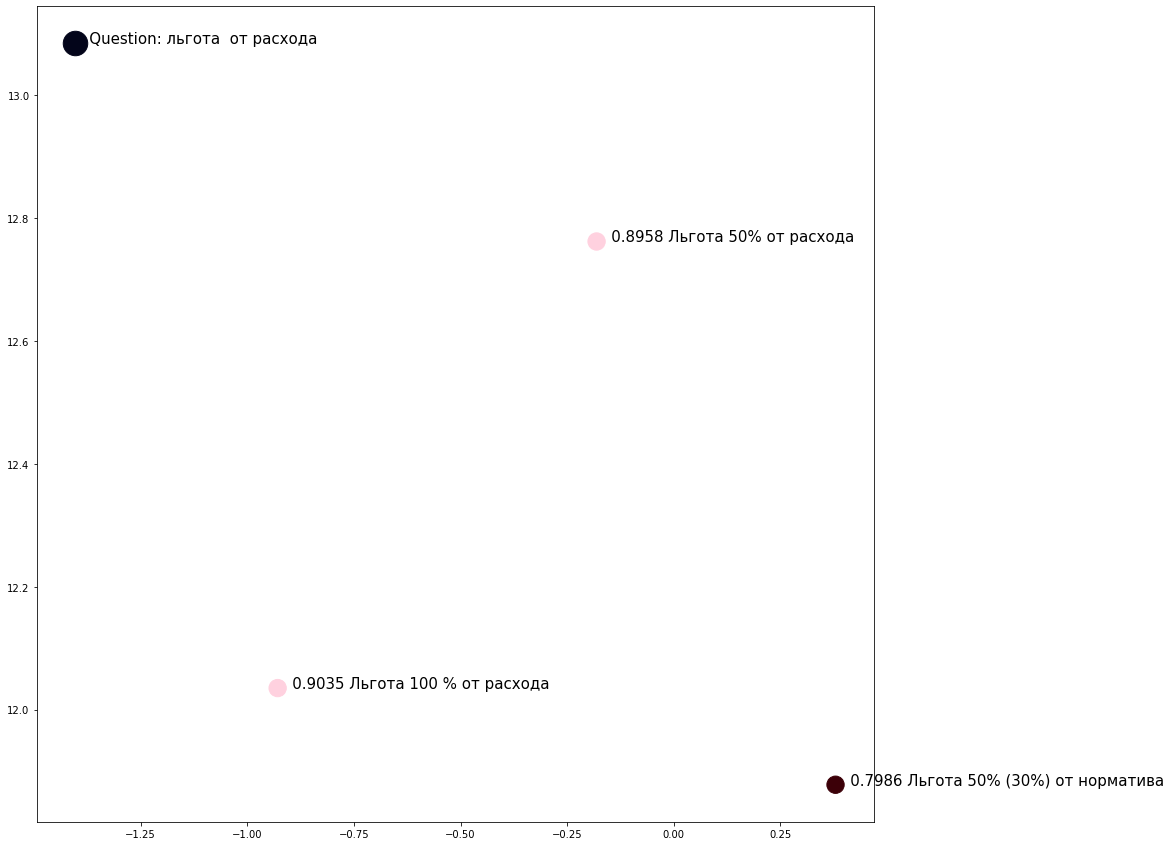

Wall time: 1.98 s


In [138]:
%%time
noise=' пук кряк пиво интерал'
noise2=' а то я не умею'
question=faq['Question'][51] +noise2+noise
#question='Как оформить льготу '
question='льгота  от расхода'
#question='Как будут осуществляться начисления если счетчик сломается'


eps=0.15
minimal_score=0.6
beta=1.5

modes=['fasttext','sbert']
mode=modes[1]

output=find_faq(engine,question,eps,minimal_score,mode=mode,verbose=True,plot=True)

In [ ]:
def clean_question(vectorizer,question,pred_questions,min_score):
    question_words=question.split()
    question_words_embs=[vectorizer(word) for word in question_words]
    
    pred_question_words=[]
    for pred_question in pred_questions:
        words=pred_question.split()
        pred_question_words=pred_question_words+words
    
    pred_question_words_embs=[vectorizer(word) for word in pred_question_words]
    
    dlt_inx=[]
    
    for i,question_word_emb in enumerate(question_words_embs):
        word_score=0
        for j,pred_question_word_emb in enumerate(pred_question_words_embs):
            score=1-spatial.distance.cosine(question_word_emb, pred_question_word_emb)
            if score > word_score:
                word_score=score
                
        if word_score<min_score:
            dlt_inx.append(i)
            
    for i in reversed(dlt_inx):
        question_words.pop(i)
    
    return " ".join(question_words)

In [ ]:
questions=['Сборка простой люстры',
'Сборка сложной люстры',
'Установка простой люстры',
'Установка сложной люстры',
'Установка светильника типа Армстронг',
'Установка светильника настенного, бра',
'Установка точечного светильника',
'Подключение светильника Выход',
'Подключени трансформатора для галогенных ламп',
'Установка антивандального светильника']


In [ ]:
q1=questions[:2]
q1

In [ ]:
q2=questions[4:7]
q2_words=[]
morph = pymorphy2.MorphAnalyzer()

for q in q2:
    words=q.split()
    for word in words:
        p = morph.parse(word)[0] 
        q2_words.append(p.normal_form)
        
q2_words=set(q2_words)
q2

In [ ]:
q2_words

In [ ]:


word = "светильником"
p = morph.parse(word)[0]  # Делаем полный разбор, и берем первый вариант разбора (условно "самый вероятный", но не факт что правильный)
print(p.normal_form)  # стать